In [1]:
import mido
import os
import numpy as np
from scipy import stats
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow.contrib import rnn
import time

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (12, 8)

In [2]:
TICKS_PER_BEAT = 480
TEMPO = int(mido.bpm2tempo(120))

In [64]:
%run get_training_data.py

### Create training data

In [65]:
def get_training_data(start_index, end_index):
    """Generate training data array for all files in "midis_processed/" directory.
       
    Returns:
        Numpy array of training data.
    """
    training_data = []
    training_data_labels = []
    for filename in os.listdir('midis_processed/')[start_index:end_index]:
        if filename.endswith(".mid"):
            vector = midi_to_vector('midis_processed/' + filename)
            if len(vector) > 100:
                training_data.append(np.array(vector))
                training_data_labels.append(filename)
            else:
                print("Faulty training data: " + filename + ". len(vector)=" + str(len(vector)))
    return np.array(training_data), training_data_labels

In [66]:
# Set num training examples here. Note: actual number will be less, since some have errors
training_data, training_data_labels = get_training_data(13, 14)

In [67]:
print("Number of training examples:", len(training_data))
training_data_labels

Number of training examples: 1


['3D_Worldrunner_Main.mid']

### Data Profiling

In [69]:
index = 0
data = training_data[index]
training_data_labels[index]

'3D_Worldrunner_Main.mid'

In [70]:
data.shape

(5572, 1120)

In [71]:
vocab_size = data.shape[1]

In [72]:
labels = data.dot(range(vocab_size))
labels[:10]

array([ 207,  427, 1070,  719,  939, 1024,  206,  429, 1069,  718])

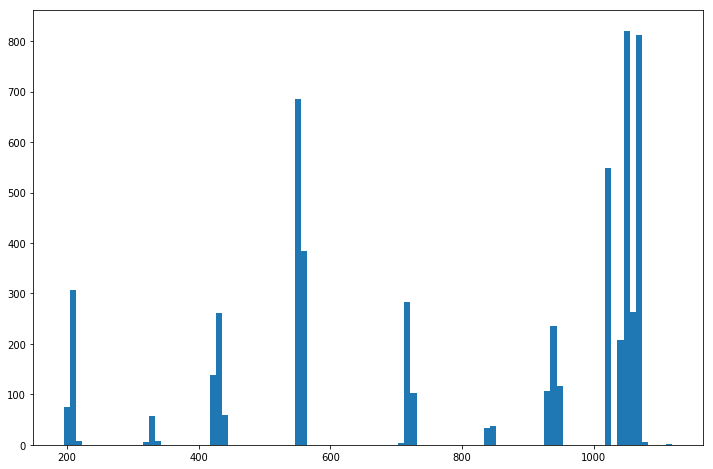

In [73]:
plt.hist(labels, bins=100)
plt.show()

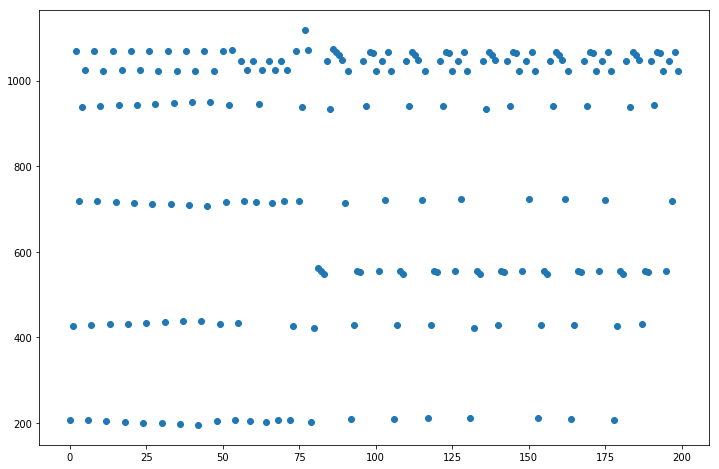

array([ 207,  427, 1070,  719,  939, 1024,  206,  429, 1069,  718,  941,
       1023,  204,  431, 1070,  716,  943, 1024,  202,  432, 1069,  714,
        944, 1024,  200,  434, 1070,  712,  946, 1023,  199,  436, 1070,
        711,  948, 1023,  197,  438, 1070,  709,  950, 1023,  195,  439,
       1070,  707,  951, 1023,  204,  432, 1069,  716,  944, 1072,  206,
        434, 1045,  718, 1024,  204, 1045,  716,  946, 1024,  202, 1045,
        714, 1024,  206, 1045,  718, 1024,  207,  427, 1069,  719,  939,
       1119, 1072,  202,  422,  561,  554,  548, 1046,  934, 1073, 1066,
       1060, 1047,  714, 1023,  209,  429,  554,  552, 1046,  941, 1066,
       1064, 1023,  556, 1046,  721, 1068, 1023,  209,  429,  554,  548,
       1046,  941, 1066, 1060, 1047,  721, 1023,  211,  429,  554,  552,
       1046,  941, 1066, 1064, 1023,  556, 1046,  723, 1068, 1023,  212,
        422,  554,  548, 1046,  934, 1066, 1060, 1047,  429,  554,  552,
       1046,  941, 1066, 1064, 1023,  556, 1046,  7

In [74]:
N = 200
plt.scatter(range(N), labels[:N])
plt.show()
labels[:N]